#Import

In [1]:
# Import Required libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import tarfile

#Dataset

In [2]:
url = ' https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
filename = 'flower_photos.tgz'
urllib.request.urlretrieve(url, filename)

# unzip it
filename = "flower_photos.tgz"
tf = tarfile.open(filename)
tf.extractall()

##Check

In [3]:
# This is the directory path where all the class folders are
dir_path =  'flower_photos'
 
# Initialize classes list, this list will contain the names of our classes.
classes = []
 
# Iterate over the names of each class
for class_name in os.listdir(dir_path):
 
   # Get the full path of each class
  class_path = os.path.join(dir_path, class_name)
  
  # Check if the class is a directory/folder
  if os.path.isdir(class_path):
 
      # Get the number of images in each class and print them
      No_of_images = len(os.listdir(class_path))
      print("Found {} images of {}".format(No_of_images , class_name))
 
      # Also store the name of each class
      classes.append(class_name)
 
# Sort the list in alphabatical order and print it    
classes.sort()
print(classes)

Found 898 images of dandelion
Found 799 images of tulips
Found 641 images of roses
Found 633 images of daisy
Found 699 images of sunflowers
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#Generation of Training- & Validation-dataset

In [6]:
# Set the batch size, width, height and the percentage of the validation split.
batch_size = 60
IMG_HEIGHT = 224
IMG_WIDTH = 224
split = 0.2


#  Setup the ImagedataGenerator for training, pass in any supported augmentation schemes, notice that we're also splitting the data with split argument.
datagen_train = ImageDataGenerator(
    rescale=1./255, 
    validation_split= split,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect')

# Setup the ImagedataGenerator for validation, no augmentation is done, only rescaling is done, notice that we're also splitting the data with split argument.
datagen_val = ImageDataGenerator(
    rescale=1./255, 
    validation_split=split) 


# Data Generation for Training with a constant seed valued 40, notice that we are specifying the subset as 'training'
train_data_generator = datagen_train.flow_from_directory(batch_size=batch_size,
                                                           directory=dir_path,
                                                           shuffle=True,
                                                           seed = 40,
                                                           subset= 'training',
                                                           interpolation = 'bicubic',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

# Data Generator for validation images with the same seed to make sure there is no data overlap, notice that we are specifying the subset as 'validation'
vald_data_generator = datagen_val.flow_from_directory(batch_size=batch_size, 
                                                           directory=dir_path,
                                                           shuffle=True,
                                                           seed = 40,
                                                           subset = 'validation',
                                                           interpolation = 'bicubic',
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

# The "subset" variable tells the Imagedatagerator class which generator gets 80% and which gets 20% of the data

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


#Visualize Images

In [7]:
# Here we are creating a function for displaying images of flowers from the data generators

def display_images(data_generator, no = 15):
    sample_training_images, labels = next(data_generator)

    plt.figure(figsize=[25,25])

    # By default we're displaying 15 images, you can show more examples
    total_samples = sample_training_images[:no]

    cols = 5
    rows  =   np.floor( len(total_samples) / cols )

    for i, img in enumerate(total_samples, 1):

            plt.subplot(rows, cols, i );plt.imshow(img);

            # Converting One hot encoding labels to string labels and displaying it.
            class_name = classes[np.argmax(labels[i-1])]
            plt.title(class_name);plt.axis('off');

#Display Images

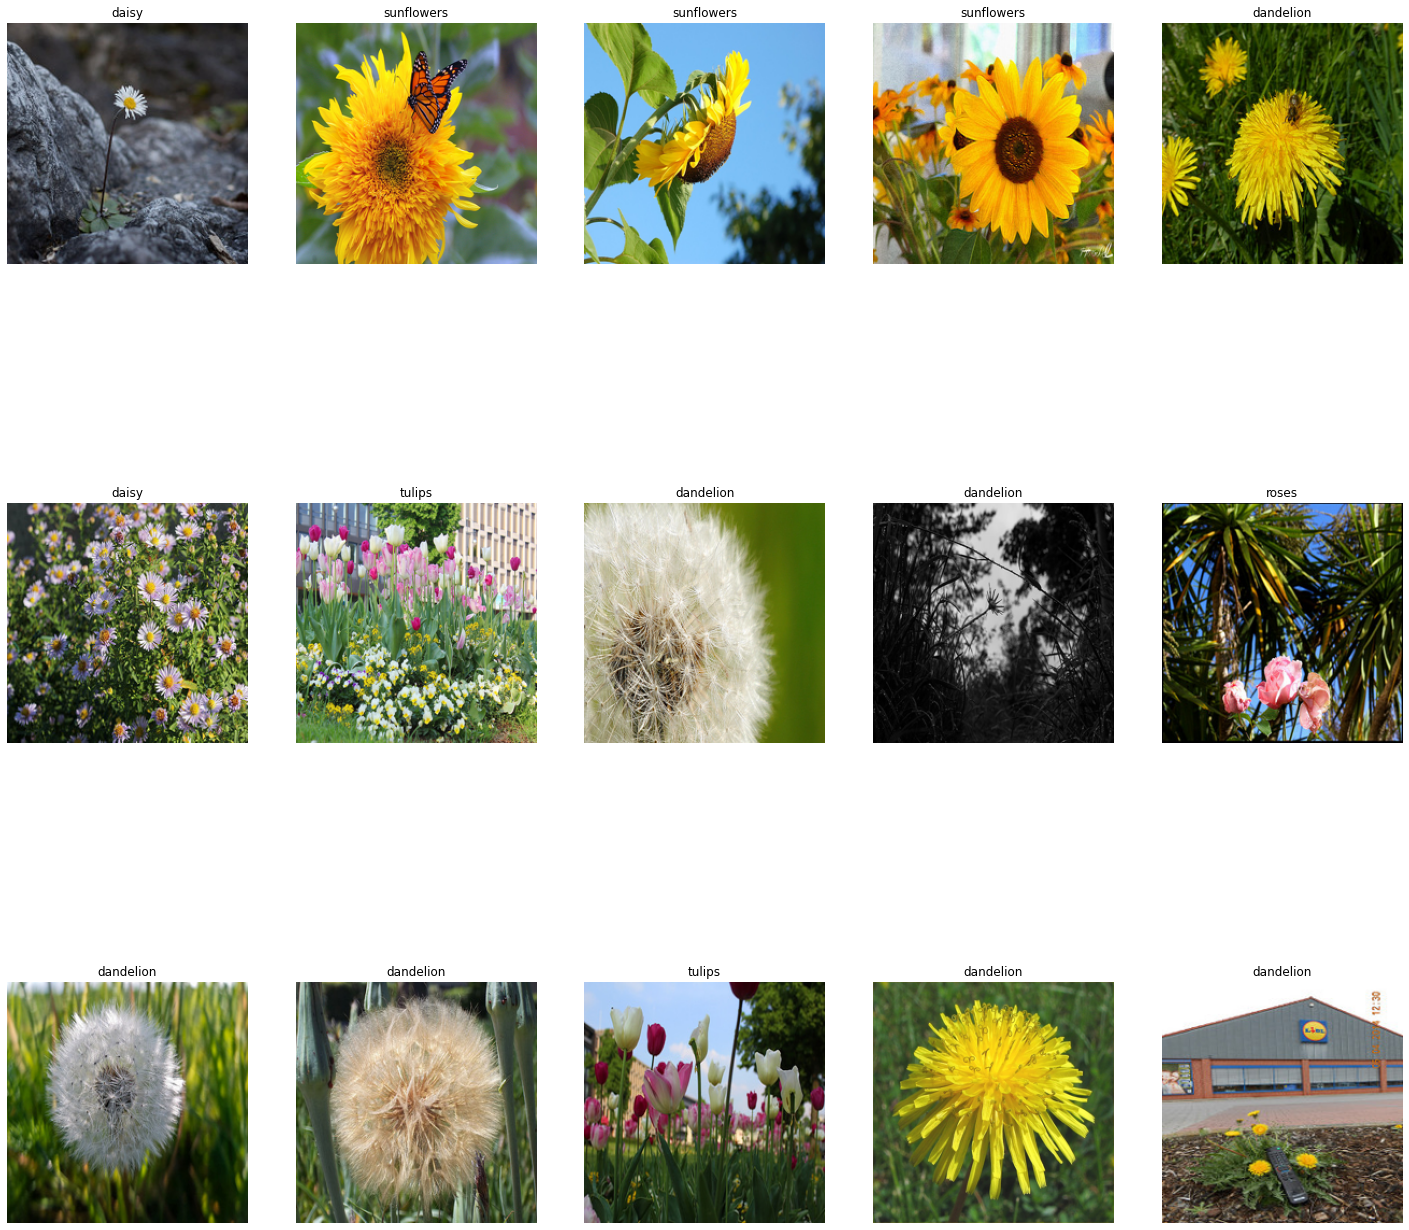

In [8]:
# Display Original Images
display_images(vald_data_generator)

#Create CNN

In [9]:
# First Reset the generators, since we used the first batch to display the images.
vald_data_generator.reset()
train_data_generator.reset()

# Here we are creating Sequential model also defing its layers
model = Sequential([
      Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
      MaxPooling2D(),
      Dropout(0.10),

      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(128, 3, padding='same', activation='relu'),
      MaxPooling2D(),

      Conv2D(256, 3, padding='same', activation='relu'),
      MaxPooling2D(),
    
      GlobalAveragePooling2D(),
      Dense(1024, activation='relu'),
      Dropout(0.10),
      Dense(len(classes), activation ='softmax')
  ])

#Compile Model

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

#Training

In [12]:
# Define the epoch number 
epochs = 60

# Start Training
history = model.fit( train_data_generator,  steps_per_epoch= train_data_generator.samples // batch_size, epochs=epochs, validation_data= vald_data_generator,
    validation_steps = vald_data_generator.samples // batch_size )

# Use model.fit_generator() if using TF version &lt; 2.2

Epoch 1/60
48/48 [==============================] - 40s 841ms/step - loss: 1.5757 - accuracy: 0.2626 - val_loss: 1.4967 - val_accuracy: 0.3292
Epoch 2/60
48/48 [==============================] - 40s 844ms/step - loss: 1.3427 - accuracy: 0.4344 - val_loss: 1.2098 - val_accuracy: 0.4750
Epoch 3/60
48/48 [==============================] - 40s 840ms/step - loss: 1.0969 - accuracy: 0.5318 - val_loss: 1.1050 - val_accuracy: 0.5375
Epoch 4/60
48/48 [==============================] - 40s 841ms/step - loss: 1.0618 - accuracy: 0.5641 - val_loss: 1.0797 - val_accuracy: 0.5347
Epoch 5/60
48/48 [==============================] - 40s 840ms/step - loss: 0.9621 - accuracy: 0.5995 - val_loss: 1.0114 - val_accuracy: 0.5819
Epoch 6/60
48/48 [==============================] - 41s 848ms/step - loss: 0.9386 - accuracy: 0.6217 - val_loss: 0.9673 - val_accuracy: 0.6028
Epoch 7/60
48/48 [==============================] - 40s 842ms/step - loss: 0.8975 - accuracy: 0.6412 - val_loss: 0.9246 - val_accuracy: 0.6264

#Plots

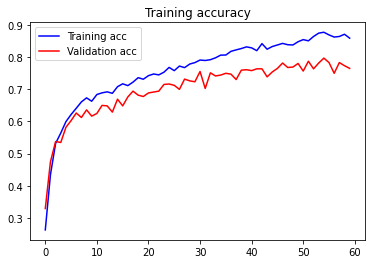

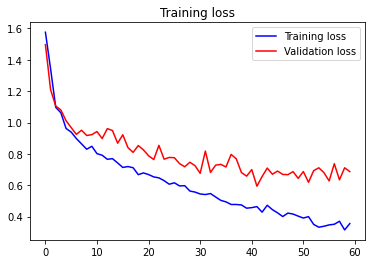

In [13]:
# Plot the accuracy and loss curves for both training and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

# Test model

Predicted Flowers is : tulips 55.58%


(-0.5, 999.5, 999.5, -0.5)

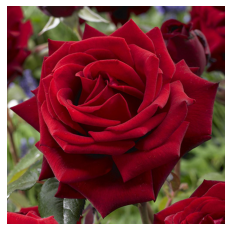

In [20]:
# Read the rose image
img = cv2.imread('/rose.jpg')

# Resize the image to the size you trained on.
imgr= cv2.resize(img,(224,224))

# Convert image BGR TO RGB, since OpenCV works with BGR and tensorflow in RGB.
imgrgb = cv2.cvtColor(imgr, cv2.COLOR_BGR2RGB)

# Normalize the image to be in range 0-1 and then convert to a float array.
final_format = np.array([imgrgb]).astype('float64') / 255.0

# Perform the prediction
pred = model.predict(final_format)

# Get the index of top prediction
index = np.argmax(pred[0])

# Get the max probablity for that prediction
prob = np.max(pred[0])

# Get the name of the predicted class using the index
label = classes[index]

# Display the image and print the predicted class name with its confidence.
print("Predicted Flowers is : {} {:.2f}%".format(label, prob*100))
plt.imshow(img[:,:,::-1]);plt.axis("off")

# Save model

In [21]:
# Saving your model to disk allows you to use it later
model.save('flowers.h5')

# Later on you can load your model this way
#model = load_model('Model/flowers.h5')